# Choose Planets

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from astropy import constants as const
import warnings
warnings.filterwarnings("ignore")
import math
import time

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

import scipy
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import multivariate_normal
from scipy.stats import bootstrap
from scipy import interpolate
from scipy.optimize import curve_fit


In [2]:
dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improved_210721.csv",delimiter=",")
#ataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\EPA.txt.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\2024sample_composite.csv",delimiter=",")

dataLInew = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\stpm_230202.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI
planet_LI_NEW         = list(dataLInew["Star"]+" "+dataLInew["Planet"])
dataLInew["planet_name"] = planet_LI_NEW
earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Luque Impoved New
planet3 = planet_LI_NEW 
# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [4]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1      = []; planet_i1       = []; planet_eq1   = []
disc_year1   = []; st_eff1         = []; st_type1     = []
radius1      = []; radius_up1      = []; radius_low1  = []
mass1        = []; mass_up1        = []; mass_low1    = []
density1     = []; density_up1     = []; density_low1 = []

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        planet1.append(planet_name_LI[i]); planet_eq1.append(pl_eq_LI[i]);          st_eff1.append(star_eff_LI[i]);
        radius1.append(radius_LI[i]);      radius_up1.append(radius_unc_up_LI[i]);  radius_low1.append(radius_unc_low_LI[i]);
        mass1.append(mass_LI[i]);          mass_up1.append(mass_unc_up_LI[i]);      mass_low1.append(mass_unc_low_LI[i]);
        density1.append(density_LI[i]);    density_up1.append(density_unc_up_LI[i]); density_low1.append(density_unc_low_LI[i]);

In [5]:
planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    st_eff2.append(st_eff_EA[i])
    planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
    radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
    density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
    mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


In [6]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

In [7]:
mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

planet_temp = np.concatenate((planet_eq1, planet_eq2));
planet_name = np.concatenate((planet1,    planet2));

mass_err    = [np.abs(mass_low),mass_up]
radius_err  = [np.abs(radius_low),radius_up]
density_err = [np.abs(density_low),density_up]

mass10      = np.log10(mass)
mass10_up   = np.log10(mass + mass_up) - np.log10(mass)
mass10_low  = np.log10(mass + np.abs(mass_low)) - np.log10(mass)
mass10_err  = [mass10_low,mass10_up]

model_rocky_density = np.array(rocky_density(np.array(earth_like_rocky["Mass"])))
model_rocky_mass    = np.array(earth_like_rocky["Mass"])
model_rocky10_mass  = np.array(np.log10(np.array(earth_like_rocky["Mass"])))
model_rocky_radius  = np.array(earth_like_rocky["Radius"])

# Show Data

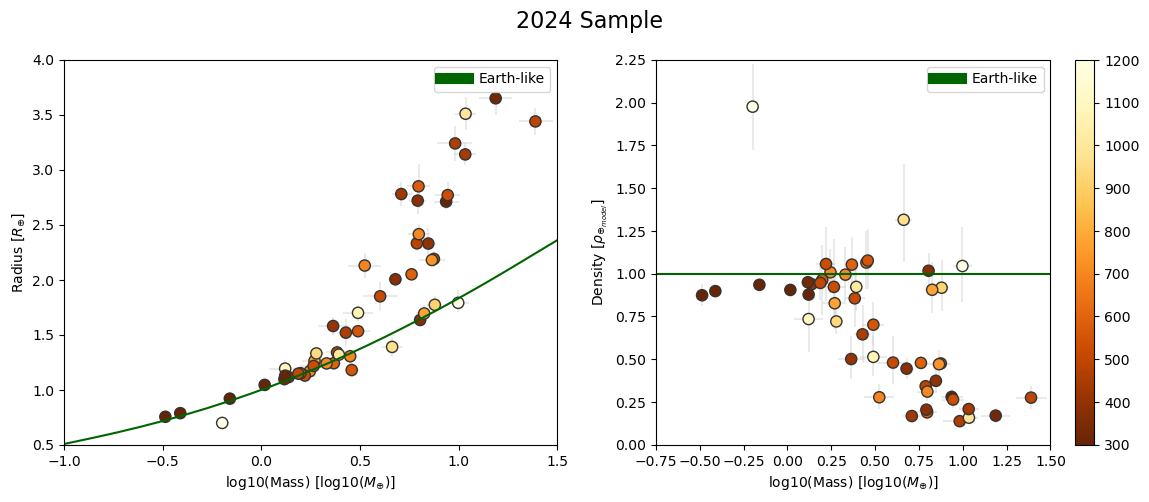

In [8]:
fig, ax = plt.subplots(figsize=(14,5))
fig.suptitle('2024 Sample', fontsize=16)

plt.subplot(1, 2, 1)
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
plt.plot(np.log10(list(earth_like_rocky["Mass"])),list(earth_like_rocky["Radius"]),"-",color = "Darkgreen",label = "Earth-like")
plt.scatter(mass10, radius, c=planet_temp, cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
plt.errorbar(mass10, radius,xerr = mass10_err, yerr = radius_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)

plt.xlim(-1,1.5)
plt.ylim(0.5,4)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Radius $[R_{\oplus}]$")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.subplot(1, 2, 2)
plt.scatter(mass10, density, c=planet_temp, cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")

plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
cbar = plt.colorbar()

# Trial Things

Silhouette Score: 0.360974812612495
Calinski-Harabasz Score: 14.508564917136425


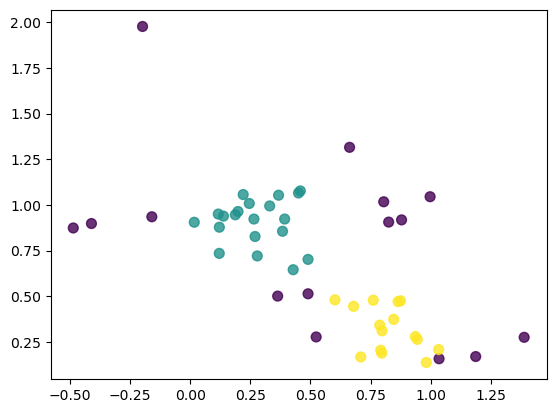

In [53]:
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.26, min_samples=15)
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
silhouette_avg = silhouette_score(df, labels)
print(f"Silhouette Score: {silhouette_avg}")
ch_score = calinski_harabasz_score(df, labels)
print(f"Calinski-Harabasz Score: {ch_score}")

In [49]:
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.26, min_samples=15)
labels = dbscan.fit_predict(df)

label_list   = []
mass_list    = []
density_list = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i])
        mass_list.append(mass10[i])
        density_list.append(density[i])
        
dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})

silhouette_avg = silhouette_score(dfs, label_list)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.7064597500396593


In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

# Assuming 'mass10' and 'density' are your input data arrays
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.3, min_samples=15)
labels = dbscan.fit_predict(df)

# Extracting points belonging to clusters (excluding outliers)
label_list = []
mass_list = []
density_list = []
for i in range(len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i])
        mass_list.append(mass10[i])
        density_list.append(density[i])

dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})

# Calculating silhouette score for the subset of data points
silhouette_avg = silhouette_score(dfs, label_list)
print(f"Silhouette Score: {silhouette_avg}")

# Calculating silhouette scores for each data point
silhouette_vals = silhouette_samples(dfs, label_list)


Silhouette Score: 0.6405013860692483


Silhouette Score: 0.7064597500396593


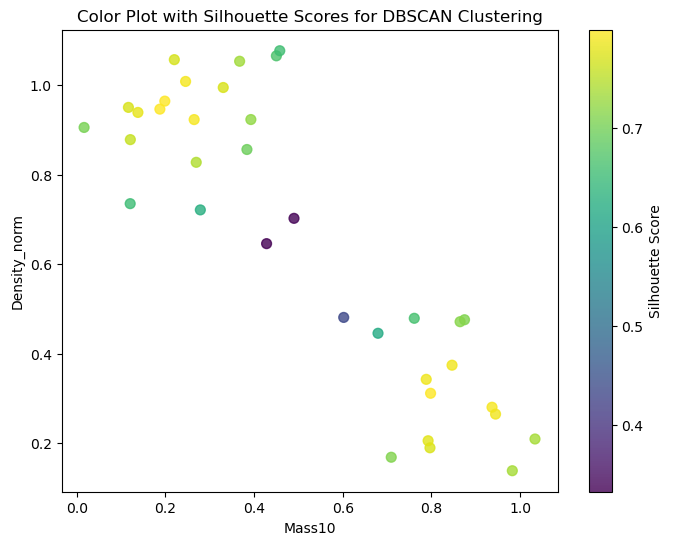

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=0.27, min_samples=15)
labels = dbscan.fit_predict(df)

label_list   = []
mass_list    = []
density_list = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i])
        mass_list.append(mass10[i])
        density_list.append(density[i])
        
dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})

silhouette_avg = silhouette_score(dfs, label_list)
print(f"Silhouette Score: {silhouette_avg}")

silhouette_vals = silhouette_samples(dfs, label_list)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(dfs['Mass_list'], dfs['density_list'], c=silhouette_vals, cmap='viridis', s=50, alpha=0.8)

cbar = plt.colorbar(scatter)
cbar.set_label('Silhouette Score')

ax.set_xlabel("Mass10")
ax.set_ylabel("Density_norm")
ax.set_title("Color Plot with Silhouette Scores for DBSCAN Clustering")

plt.show()


In [52]:
min(silhouette_vals)

0.33224874454658604

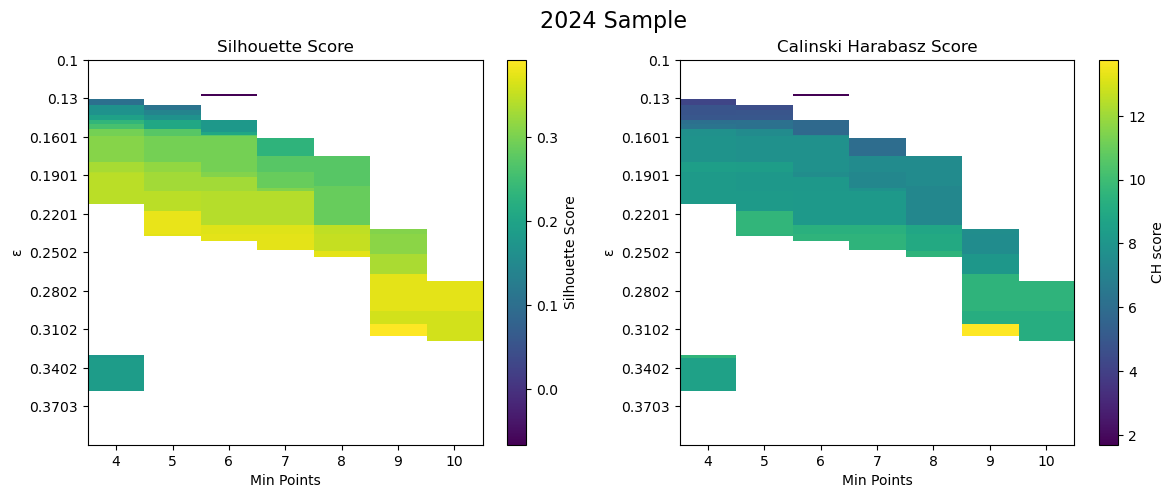

In [311]:
fig, ax = plt.subplots(figsize=(14,5))
fig.suptitle('2024 Sample', fontsize=16)

plt.subplot(1, 2, 1)
data = np.array([SS4,SS5, SS6, SS7,SS8,SS9,SS10]).T.astype(float)  # Convert to float
plt.imshow(data, cmap='viridis', aspect='auto', interpolation='none')

cbar = plt.colorbar()
cbar.set_label("Silhouette Score")

plt.xticks(np.arange(7), ['4','5', '6', '7','8','9','10'])
plt.yticks(np.arange(0, len(esps), 100), np.round(esps[::100], 4))  # Plot every 10 ticks
plt.ylabel('ε')
plt.xlabel('Min Points')
plt.title('Silhouette Score')

plt.subplot(1, 2, 2)
data = np.array([CH4,CH5, CH6, CH7,CH8,CH9,CH10]).T.astype(float)  # Convert to float
plt.imshow(data, cmap='viridis', aspect='auto', interpolation='none')
cbar = plt.colorbar()
cbar.set_label("CH score")
plt.xticks(np.arange(7), ['4','5', '6', '7','8','9','10'])
plt.yticks(np.arange(0, len(esps), 100), np.round(esps[::100], 4))  # Plot every 10 ticks
plt.ylabel('ε')
plt.xlabel('Min Points')
plt.title('Calinski Harabasz Score')
plt.show()

Silhouette Score: 0.41792235831519653
Calinski-Harabasz Score: 18.1092212589516


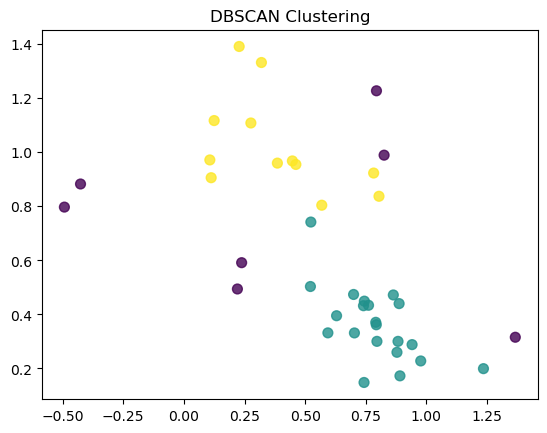

In [435]:
dbscan = DBSCAN(eps=esps[max_index], min_samples=7)
labels = dbscan.fit_predict(df)
if -1 in labels and 0 in labels:
    plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.title('DBSCAN Clustering')
    silhouette_avg = silhouette_score(df, labels)
    print(f"Silhouette Score: {silhouette_avg}")
    ch_score = calinski_harabasz_score(df, labels)
    print(f"Calinski-Harabasz Score: {ch_score}")
elif -1 in labels:
    print("No clusters detected")
else:
    print("All planets 1 big cluster")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt

silhouette_vals = silhouette_samples(dfs, label_list)

# Plotting the silhouette score plot
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10

for i in range(max(label_list) + 1):
    cluster_silhouette_vals = silhouette_vals[label_list == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)

    # Fill the area between vertical lines at y_lower and y_upper with the silhouette color
    color = plt.cm.viridis(float(i) / (max(label_list) + 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plot with the cluster number at the middle
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))

    # Compute the new y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# Set labels and title
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title("Silhouette plot")

# Show the average silhouette score
silhouette_avg = silhouette_vals.mean()
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label='Average Silhouette Score')

plt.legend()
plt.show()


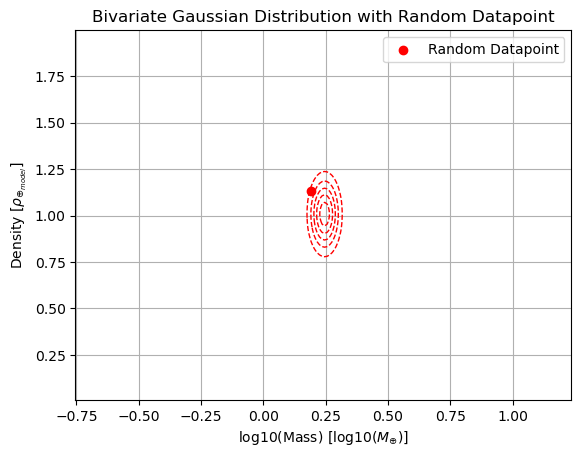

In [56]:
x     = mass10[1]
x_low = mass10_low[1]
x_up  = mass10_up[1]

y     = density[1]
y_low = density_low[1]
y_up  = density_up[1]
mean_point = np.array([x, y])
uncertainty_x = np.array([x_low, x_up]); 
uncertainty_y = np.array([y_low, y_up]);
covariance_matrix = np.diag([uncertainty_x[0]**2, uncertainty_y[0]**2])
bivariate_gaussian = multivariate_normal(mean=mean_point, cov=covariance_matrix)

random_datapoint = bivariate_gaussian.rvs()
plt.scatter(random_datapoint[0], random_datapoint[1], color='red', marker='o', label='Random Datapoint')

x, y = np.mgrid[mean_point[0]-1:mean_point[0]+1:.01, mean_point[1]-1:mean_point[1]+1:.01]
pos = np.dstack((x, y))
pdf = bivariate_gaussian.pdf(pos)
plt.contour(x, y, pdf, levels=5, colors='r', linewidths=1, linestyles='dashed', label='Bivariate Gaussian Contours')

plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.grid()
plt.title('Bivariate Gaussian Distribution with Random Datapoint')
plt.legend()


# Bootstrap Full


In [171]:
start_time = time.time()
esps   = np.linspace(0.1,0.4,200)
SS_save = {}
CH_save = {}
min_samples_range = range(3, 21)
np.random.seed()
number_of_bootstraps = 100
for j in range(0,number_of_bootstraps):
    xs = []; ys = [];
    for i in range(0,len(mass10)):
        x     = mass10[i]; x_low = mass10_low[i]; x_up  = mass10_up[i]
        y     = density[i]; y_low = density_low[i]; y_up  = density_up[i]
        mean_point = np.array([x, y])
        uncertainty_x = np.array([x_low, x_up]);  uncertainty_y = np.array([y_low, y_up]);
        covariance_matrix = np.diag([uncertainty_x[0]**2, uncertainty_y[0]**2])
        bivariate_gaussian = multivariate_normal(mean=mean_point, cov=covariance_matrix)
        random_datapoint = bivariate_gaussian.rvs()
        xs.append(random_datapoint[0]); ys.append(random_datapoint[1])
        
        df = pd.DataFrame({'Mass10': xs, 'Density_norm': ys})
    SS_dict = {}
    CH_dict = {}
    for min_samples in min_samples_range:
        SS_key = f"SS{min_samples}"
        CH_key = f"CH{min_samples}"
        SS_dict[SS_key] = []
        CH_dict[CH_key] = []
        for eps_value in esps:
            dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
            labels = dbscan.fit_predict(df)
            if -1 in labels and 0 in labels and 1 in labels and 3 not in labels:
                label_list   = []; mass_list    = []; density_list = []
                for i in range(0,len(mass10)):
                    if labels[i] != -1:
                        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
                        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
                silhouette = silhouette_score(dfs, label_list)
                ch_score = calinski_harabasz_score(dfs, label_list)
                SS_dict[SS_key].append(silhouette)
                CH_dict[CH_key].append(ch_score)
            else:
                SS_dict[SS_key].append(0)
                CH_dict[CH_key].append(0)
        if j != 0:
            SS_save[SS_key] = np.array(SS_save[SS_key]) + np.array(SS_dict[SS_key])
            CH_save[CH_key] = np.array(CH_save[CH_key]) + np.array(CH_dict[CH_key])
    if j == 0:
        SS_save = SS_dict
        CH_save = CH_dict
    print(str(j),end = " ")
end_time = time.time()

print(f"\nTotal execution time: {end_time - start_time:.2f} seconds.")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Total execution time: 5686.81 seconds.


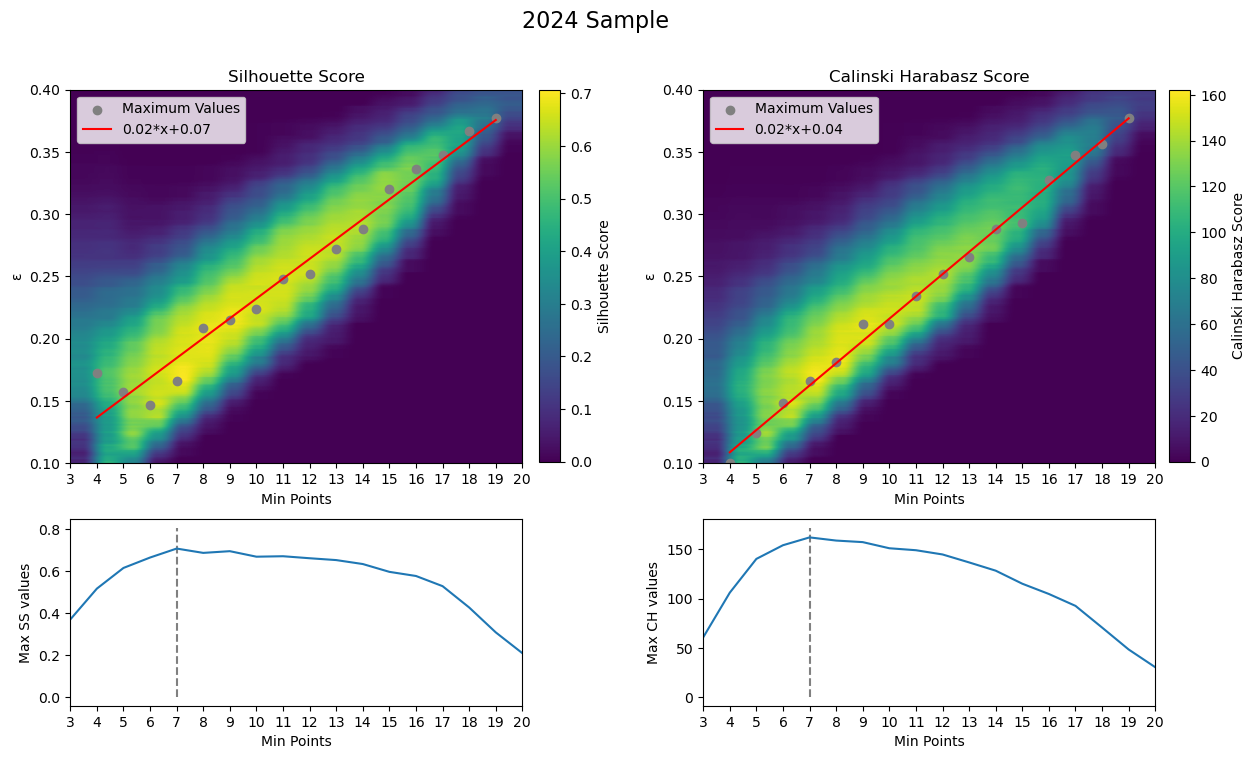

In [180]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle('2024 Sample', fontsize=16)

gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[2, 1], wspace=0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})

# Plot for Silhouette Score
ax1 = plt.subplot(gs[0, 0])
data = np.array([SS_save[f"SS{i}"] for i in range(3, 21)]).T.astype(float) /number_of_bootstraps
img1 = ax1.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax1.set_xticks(np.arange(3, 21, 1))
ax1.set_xticklabels([f"{i}" for i in range(3, 21)])
ax1.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax1.set_ylabel('ε')
ax1.set_xlabel('Min Points')
ax1.set_title('Silhouette Score')

esps_SS = []; max_SS_list = []
for i in range(3, 21):
    SS_array = np.array([SS_save[f"SS{i}"]])
    max_index = np.argmax(SS_array)
    max_SS_list.append(SS_save[f"SS{i}"][max_index])
    esps_SS.append(esps[max_index])

x_values_SS = list(range(4, 20))
y_values_SS = esps_SS[1:-1]
slope_SS, intercept_SS = np.polyfit(x_values_SS, y_values_SS, 1)
ax1.scatter(x_values_SS, y_values_SS, label='Maximum Values', color="grey")
x_fit_SS = np.linspace(min(x_values_SS), max(x_values_SS), 100)
y_fit_SS = slope_SS * x_fit_SS + intercept_SS
ax1.plot(x_fit_SS, y_fit_SS, color='red', label=f'{np.round(slope_SS,2)}*x+{np.round(intercept_SS,2)}')
ax1.legend()

# Plot for Calinski Harabasz Score
ax2 = plt.subplot(gs[0, 1], sharex=ax1)
data = np.array([CH_save[f"CH{i}"] for i in range(3, 21)]).T.astype(float)/number_of_bootstraps
img2 = ax2.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax2.set_xticks(np.arange(3, 21, 1))
ax2.set_xticklabels([f"{i}" for i in range(3, 21)])
ax2.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax2.set_ylabel('ε')
ax2.set_xlabel('Min Points')
ax2.set_title('Calinski Harabasz Score')

esps_CH = []
max_CH_list = []
for i in range(3, 21):
    CH_array = np.array([CH_save[f"CH{i}"]])
    max_index = np.argmax(CH_array)
    max_CH_list.append(CH_save[f"CH{i}"][max_index])
    esps_CH.append(esps[max_index])

x_values_CH = list(range(4, 20))
y_values_CH = esps_CH[1:-1]
slope_CH, intercept_CH = np.polyfit(x_values_CH, y_values_CH, 1)
ax2.scatter(x_values_CH, y_values_CH, label='Maximum Values', color="grey")
x_fit_CH = np.linspace(min(x_values_CH), max(x_values_CH), 100)
y_fit_CH = slope_CH * x_fit_CH + intercept_CH
ax2.plot(x_fit_CH, y_fit_CH, color='red', label=f'{np.round(slope_CH,2)}*x+{np.round(intercept_CH,2)}')
ax2.legend()

# Plot for Max SS values
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
ax3.vlines(7,0,max(max_SS_list)/number_of_bootstraps+0.1,color = "0.5",linestyle = "dashed")

ax3.plot(list(range(3, 21)), np.array(max_SS_list)/number_of_bootstraps)
ax3.set_xticks(np.arange(3, 21, 1))
ax3.set_xticklabels([f"{i}" for i in range(3, 21)])
ax3.set_xlabel('Min Points')
ax3.set_ylabel('Max SS values')

# Plot for Max CH values
ax4 = plt.subplot(gs[1, 1], sharex=ax2)  # Share x-axis with ax2
ax4.vlines(7,0,max(max_CH_list)/number_of_bootstraps+10,color = "0.5",linestyle = "dashed")

img4 = ax4.plot(list(range(3, 21)), np.array(max_CH_list)/number_of_bootstraps)
ax4.set_xticks(np.arange(3, 21, 1))
ax4.set_xticklabels([f"{i}" for i in range(3, 21)])
ax4.set_xlabel('Min Points')
ax4.set_ylabel('Max CH values')

cbar_ax1 = fig.add_axes([0.46, 0.415, 0.015, 0.465])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('Silhouette Score')

cbar_ax2 = fig.add_axes([0.91, 0.415, 0.015, 0.465])
cbar2 = fig.colorbar(img2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Calinski Harabasz Score')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent clipping of suptitle
image_name = 'GridSearch.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [235]:
clusters_numb = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
for j in range(3, 21):
    for i in range(0,len(esps)):
        dbscan = DBSCAN(eps=esps[i], min_samples=j)
        labels = dbscan.fit_predict(df)
        if 2 in labels:
            clusters_numb[j-3].append(3)
        else:
             clusters_numb[j-3].append(2)

In [228]:
list(range(0, 6))

[0, 1, 2, 3, 4, 5]

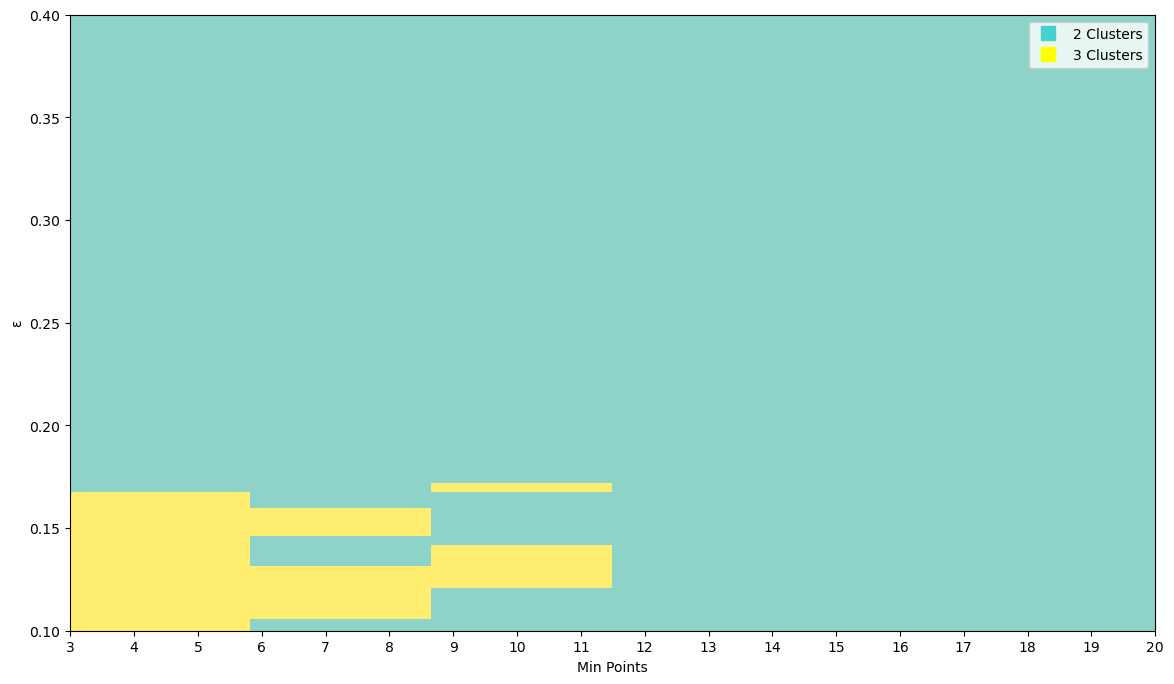

In [265]:
fig = plt.figure(figsize=(14, 8))
plt.plot(0.1,0.1,"s",label = "2 Clusters",markersize = 10,color = "mediumturquoise")
plt.plot(0.1,0.1,"s",label = "3 Clusters",markersize = 10,color = "yellow")
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
data = np.array([clusters_numb[i] for i in list(range(0, 6))]).T.astype(float)
plt.imshow(data, cmap='Set3', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
plt.xticks(np.arange(3, 21, 1),[f"{i}" for i in range(3, 21)])
plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
plt.ylabel('ε')
plt.xlabel('Min Points')
plt.xlim(3,20)
plt.legend()

31
0.5788862737888053


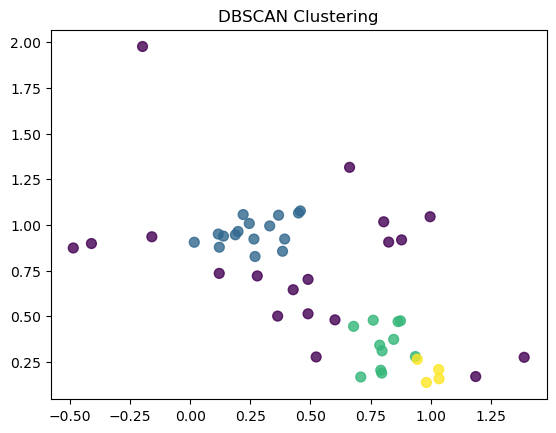

In [197]:
i = 5
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title('DBSCAN Clustering')
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)


In [198]:
labels

array([-1,  0,  0, -1, -1,  0,  0, -1,  1,  1,  0, -1,  0,  0,  1,  1, -1,
        0,  1, -1,  0,  0, -1, -1,  0,  0, -1, -1,  0,  1,  1, -1,  2, -1,
        2, -1, -1, -1,  0, -1,  1,  1,  2,  0,  0, -1,  1,  1,  2, -1],
      dtype=int64)

34
0.7437074037965631
34
0.7437074037965631


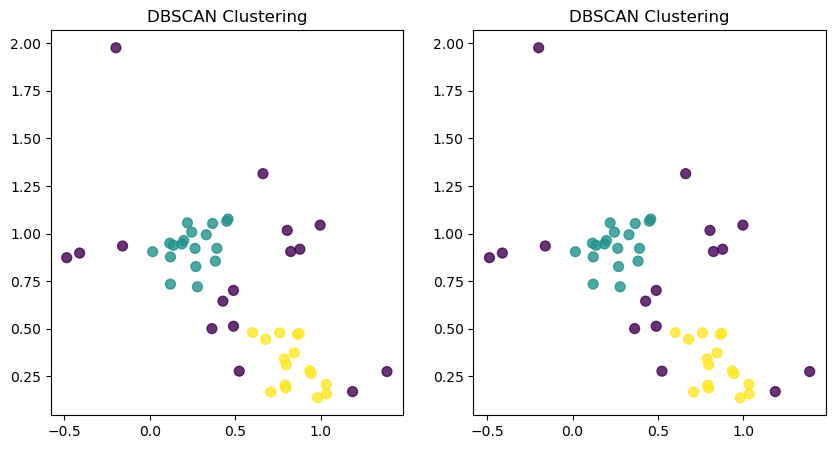

In [185]:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplot(1, 2, 1)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title('DBSCAN Clustering')
for i in range(0,len(mass10)):
    if labels[i] != -1:
        
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)

plt.subplot(1, 2, 2)
i = 8
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title('DBSCAN Clustering')
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)

34
0.7437074037965631


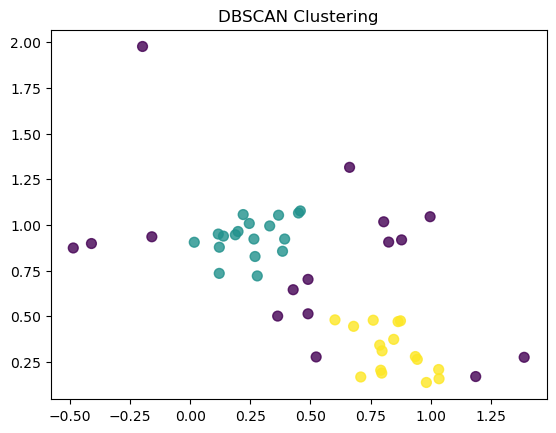

In [182]:
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
if -1 in labels and 0 in labels:
    plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.title('DBSCAN Clustering')
elif -1 in labels:
    print("No clusters detected")
else:
    print("All planets 1 big cluster")
label_list   = []; mass_list    = []; density_list = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.show()


0.6356245141466164


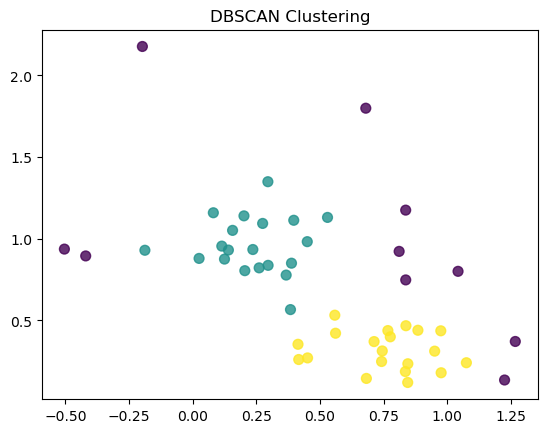

In [131]:
dbscan = DBSCAN(eps=0.24242424242424246, min_samples=8)
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title('DBSCAN Clustering')
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
silhouette = silhouette_score(dfs, label_list)
print(silhouette)

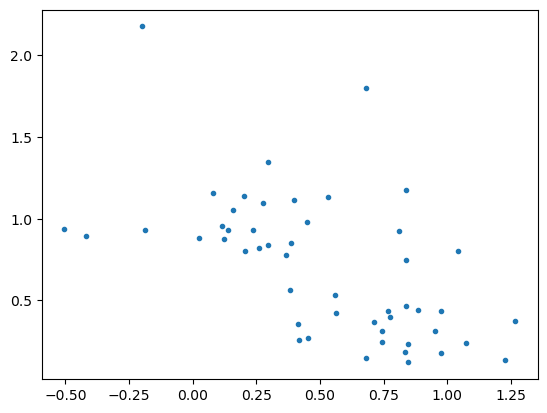

In [133]:
plt.plot(df['Mass10'],df['Density_norm'],".")

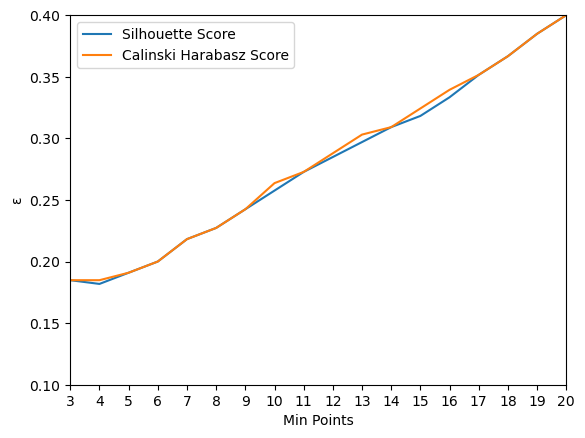

In [667]:
plt.plot(list(range(3, 21)),esps_SS,label = "Silhouette Score")
plt.plot(list(range(3, 21)),esps_CH,label = "Calinski Harabasz Score")
plt.legend()
plt.xticks(np.arange(3,21), [f"{i}" for i in range(3, 21)])
plt.xlabel('Min Points'); plt.ylabel('ε')
plt.xlim(3,20); plt.ylim(0.1,0.4)
plt.show()

In [575]:
list(range(3, 21))[10]

13

34
0.7437074037965631


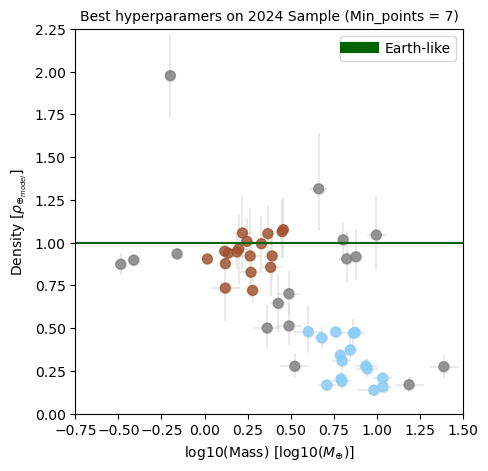

In [195]:
fig, ax = plt.subplots(figsize=(5,5))
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue")            
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
plt.title("Best hyperparamers on 2024 Sample (Min_points = 7)",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
image_name = 'DBSCAN_bestfit.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [102]:
list(range(3, 21))[6]

9

31
0.7690801660783287
34
0.7437074037965631
34
0.7437074037965631
36
0.6987036390594805


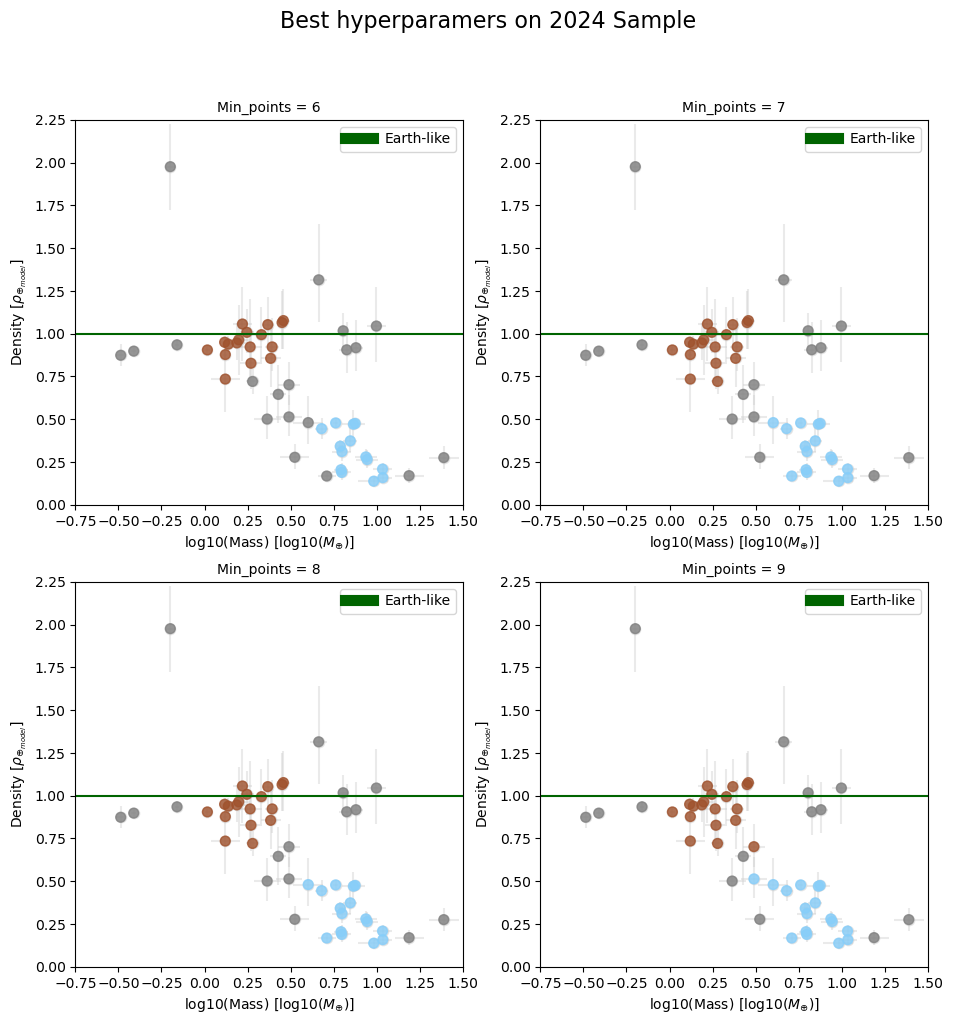

In [196]:
fig, ax = plt.subplots(figsize=(11,11))
fig.suptitle('Best hyperparamers on 2024 Sample', fontsize=16)

plt.subplot(2, 2, 1)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 6
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 6",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 2)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 7
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 7",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 3)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 8
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 8",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
    
plt.subplot(2, 2, 4)
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 9
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_CH[i-3]+esps_SS[i-3])/2, min_samples=i)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
plt.title('DBSCAN Clustering')
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
    if labels[i] == -1:
        colorlist.append("0.5")
    if labels[i] == 0:
        colorlist.append("sienna")
    if labels[i] == 1:
        colorlist.append("lightskyblue") 
plt.scatter(df['Mass10'],df['Density_norm'], c=colorlist, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)
print(len(label_list))
print(silhouette)
plt.title("Min_points = 9",fontsize = 10)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
image_name = 'DBSCAN_grid.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

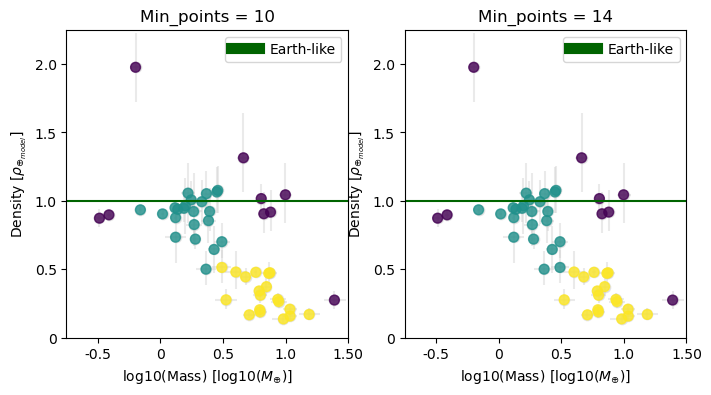

In [688]:
fig, ax = plt.subplots(figsize=(8,4))
i = 10
plt.subplot(1, 2, 1)
min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[i-3] + esps_CH[i-3]) / 2, min_samples=list(range(3, 21))[i-3])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'], df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], ["-0.5", "0", "0.5", "1.0", "1.50"])
plt.yticks([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1.0", "1.5", "2.0"])
plt.title(f"Min_points = {i}")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
i = 14
plt.subplot(1, 2, 2)
min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[i-3] + esps_CH[i-3]) / 2, min_samples=list(range(3, 21))[i-3])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'], df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], ["-0.5", "0", "0.5", "1.0", "1.50"])
plt.yticks([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1.0", "1.5", "2.0"])
plt.title(f"Min_points = {i}")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

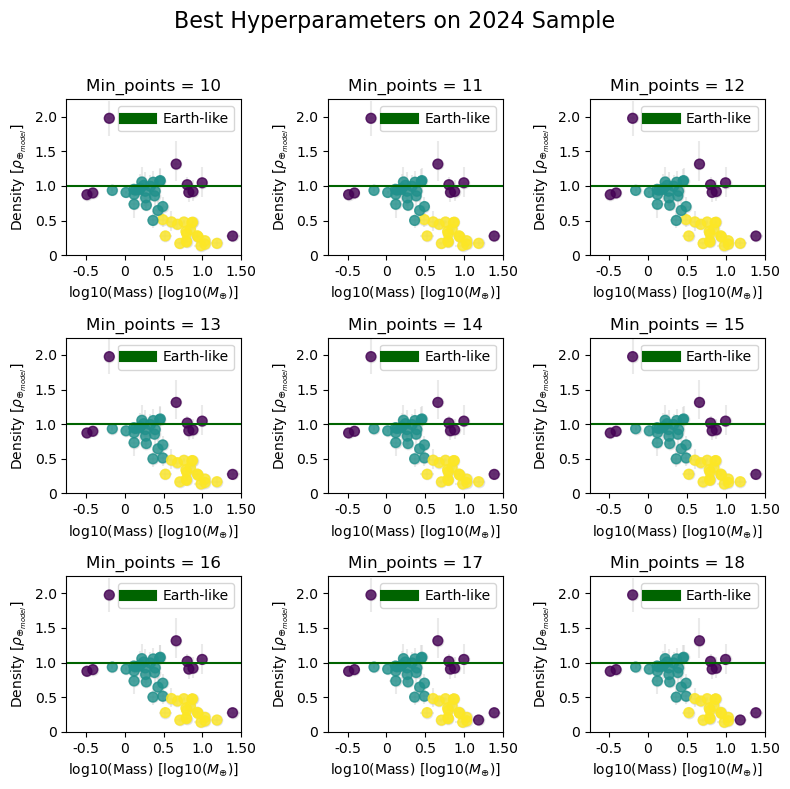

In [694]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Best Hyperparameters on 2024 Sample', fontsize=16)

for i, ax in enumerate(axes.flat, start=10):
    plt.subplot(3, 3, i - 9)
    min_points = np.arange(3, 21, 1)
    df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
    dbscan = DBSCAN(eps=(esps_SS[i-3] + esps_CH[i-3]) / 2, min_samples=list(range(3, 21))[i-3])
    labels = dbscan.fit_predict(df)
    plt.scatter(df['Mass10'], df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.xticks([-0.5, 0, 0.5, 1, 1.5], ["-0.5", "0", "0.5", "1.0", "1.50"])
    plt.yticks([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1.0", "1.5", "2.0"])
    plt.title(f"Min_points = {i}")
    plt.xlim(-0.75,1.5)
    plt.ylim(0,2.25)
    plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
    plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
    plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
    plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like")
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(8.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
image_name = 'DBSCAN_largegrid.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Best hyperparamers on 2024 Sample', fontsize=16)

plt.subplot(3, 3, 1)

min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[10]+esps_CH[10])/2, min_samples=list(range(3, 21))[10])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5,0,0.5,1,1.5],["-0.5","0","0.5","1.0","1.50"])
plt.yticks([0, 0.5,1,1.5,2],["0","0.5","1.0","1.5","2.0"])
plt.title("Min_points = 13")

plt.subplot(3, 3, 2)
min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[11]+esps_CH[11])/2, min_samples=list(range(3, 21))[11])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5,0,0.5,1,1.5],["-0.5","0","0.5","1.0","1.50"])
plt.yticks([0, 0.5,1,1.5,2],["0","0.5","1.0","1.5","2.0"])
plt.title("Min_points = 14")

plt.subplot(3, 3, 3)
min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[12]+esps_CH[12])/2, min_samples=list(range(3, 21))[12])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5,0,0.5,1,1.5],["-0.5","0","0.5","1.0","1.50"])
plt.yticks([0, 0.5,1,1.5,2],["0","0.5","1.0","1.5","2.0"])
plt.title("Min_points = 15")

plt.subplot(3, 3, 4)
min_points = np.arange(3, 21, 1)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=(esps_SS[13]+esps_CH[13])/2, min_samples=list(range(3, 21))[13])
labels = dbscan.fit_predict(df)
plt.scatter(df['Mass10'],df['Density_norm'], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.xticks([-0.5,0,0.5,1,1.5],["-0.5","0","0.5","1.0","1.50"])
plt.yticks([0, 0.5,1,1.5,2],["0","0.5","1.0","1.5","2.0"])
plt.title("Min_points = 16")


In [425]:
ss_dev = 1/ max(max(SS_save["SS3"]),max(SS_save["SS4"]),max(SS_save["SS5"]),max(SS_save["SS6"]),max(SS_save["SS7"]),max(SS_save["SS8"]),max(SS_save["SS9"]),max(SS_save["SS10"]))
ch_dev = 1/ max(max(CH_save["CH3"]),max(CH_save["CH4"]),max(CH_save["CH5"]),max(CH_save["CH6"]),max(CH_save["CH7"]),max(CH_save["CH8"]),max(CH_save["CH9"]),max(CH_save["CH10"]))

if True == False:
    plt.plot(esps,np.array(SS_save["SS3"])*ss_dev,label=  "3",c="grey")
    plt.plot(esps,np.array(CH_save["CH3"])*ch_dev,label=  "3",c="grey", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS4"])*ss_dev,label=  "4",c="blue")
    plt.plot(esps,np.array(CH_save["CH4"])*ch_dev,label=  "4",c="blue", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS5"])*ss_dev,label=  "5",c="red")
    plt.plot(esps,np.array(CH_save["CH5"])*ch_dev,label=  "5",c="red", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS6"])*ss_dev,label=  "6",c="green")
    plt.plot(esps,np.array(CH_save["CH6"])*ch_dev,label=  "6",c="green", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS7"])*ss_dev,label=  "7",c="orange")
    plt.plot(esps,np.array(CH_save["CH7"])*ch_dev,label=  "7",c="orange", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS8"])*ss_dev,label=  "8",c="yellow")
    plt.plot(esps,np.array(CH_save["CH8"])*ch_dev,label=  "8",c="yellow", linestyle = "dashed")
if True == False:
    plt.plot(esps,np.array(SS_save["SS9"])*ss_dev,label=  "9",c="purple")
    plt.plot(esps,np.array(CH_save["CH9"])*ch_dev,label=  "9",c="purple", linestyle = "dashed")
if True == True:
    plt.plot(esps,np.array(SS_save["SS10"])*ss_dev,label=  "10",c="black")
    plt.plot(esps,np.array(CH_save["CH10"])*ch_dev,label=  "10",c="black", linestyle = "dashed")
plt.vlines(0.252,0,1.05)
plt.ylim(0.8,1.05)
plt.xlim(0.1,0.3)
plt.legend(loc = 3)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20])

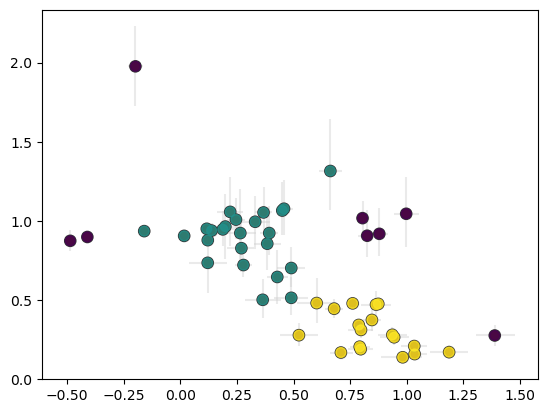

In [299]:
plt.errorbar(mass10, density,xerr = mass10_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
plt.scatter(mass10, density, c=labels, cmap=cmap, norm=norm, marker='o',s=65, edgecolors='0.2')   
plt.scatter(mass10, density, c=labels, cmap='viridis', s=50, alpha=0.8)
